# README

My Session.csv file is of size 625MB so I have not uploaded that on git hub but uploaded that on blackboard suggested by Teaching Assistant

# Abstract

Airbnb is an online marketplace and hospitality services, enabling people to lease or rent short tern lodging including vacation rentals, apartment rentals, homestays, hotel rooms. New users on airbnb can book a place to stay across countries. By accurately prredicting where new user will book their first travel experience, Airbnb can share more personalised content with their community. This will decrease the average time of first booking, and better forcast demand. We need to predict first travel destination of new user based on his personalized content. I have used xgboosting for predicting top 5 destinations where new user booked hotel, by calculating Normalized discounted cumulative gain(NDCG). It is ofte useful to measure effectiveness of web search engine algorithms. I am calculating this by encoding categorial variables.

# Data

There are 16 features used to describe each user in the dataset. They are userid, date of the account creation, timestamp of the first activity, date of first bokking, gender, age, signup method, signup flow, language, affiliate_channel, affiliate_provider, first_affiliate_tracked, signup_app, first_device_type, first_browser, country_destination


# Acknowledgement

Acknowledgements Source: All these data sets are made up of data from the US government. Data from the World Factbook is public domain. The website says "The World Factbook is in the public domain and may be used freely by anyone at anytime without seeking permission." https://www.cia.gov/library/publications/the-world-factbook/docs/faqs.html

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


Makes the random number predictable

In [2]:
np.random.seed(0)

Reading the train users and test users files

In [3]:
train_users = pd.read_csv('train_users_2.csv')
test_users = pd.read_csv('test_users.csv')

dropping country_destination column from train_users

In [4]:
labels = train_users['country_destination'].values
train_users = train_users.drop(['country_destination'], axis=1)


In [5]:
id_test = test_users['id']
piv_train = train_users.shape[0]

concatenating train_users and test_users

In [6]:
df_all = pd.concat((train_users, test_users), axis=0, ignore_index=True)

In [7]:
df_all.head()

id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender   age signup_method  signup_flow language affiliate_channel  \
0  -unknown-   NaN      facebook            0       en            direct   
1       MALE  38.0      facebook            0       en               seo   
2     FEMALE  56.0         basic            3       en            direct   
3     FEMALE  42.0      facebook            0       en            direct   
4  -unknown-  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_tracked signup_app first_device_type  \
0             direct               untracked        Web       Mac Desktop   
1             google               untracked        Web       Mac Desktop   
2             direct               untracked        Web   Windows Desktop   
3             direct               untracked        Web       Mac Desktop   
4             direct               untracked        Web       Mac Desktop   

  first_browser  
0        Chrome  
1        Chrome  
2            IE  
3       Firefox  
4        Chrome

In [8]:
df_all.isnull().values.any()

True

In [9]:
df_all.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         186639
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
dtype: int64

Dropping id and date_first_booking column from the dataset

In [10]:
df_all = df_all.drop(['id', 'date_first_booking'], axis=1)

Filling the null values

In [11]:
df_all = df_all.fillna(-1)

# User's Age

In [12]:
df_all.age.describe()

count    275547.000000
mean         26.725746
std         110.820874
min          -1.000000
25%          -1.000000
50%          25.000000
75%          35.000000
max        2014.000000
Name: age, dtype: float64

The maximum age is 2014, this is not possible. It seems that some users have filled a year instead of their age. Also the minimun age at 1 sounds rediculous. According to Airbnb's contract, users at the platform must be at least 18 years old. However, this is not enforced.

In [13]:
df_all.loc[df_all['age'] > 1000]['age'].describe()

count     828.000000
mean     2007.117150
std        22.219408
min      1920.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

So we will first correct every mistakenly filled the age.

In [14]:
df_with_year = df_all['age'] > 1000
df_all.loc[df_with_year, 'age'] = 2015 - df_all.loc[df_with_year, 'age']

According to airbnb policy age can not be less than 16 and normally people having age greater than 100 will not book hotels so allowing the users having age in between 16 to 100

In [15]:
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<16, av>100), -1, av)

Plotting the distplot of age specifying the users age 

In [16]:
plt.figure()
sns.distplot(df_all.age.dropna(), rug=True)
sns.despine()


Based on visualization It is observed that the most common age of Airbnb users is between 25 and 40.

# Users' Gender

In [17]:
df_all.head()

date_account_created  timestamp_first_active     gender   age signup_method  \
0           2010-06-28          20090319043255  -unknown-  -1.0      facebook   
1           2011-05-25          20090523174809       MALE  38.0      facebook   
2           2010-09-28          20090609231247     FEMALE  56.0         basic   
3           2011-12-05          20091031060129     FEMALE  42.0      facebook   
4           2010-09-14          20091208061105  -unknown-  41.0         basic   

   signup_flow language affiliate_channel affiliate_provider  \
0            0       en            direct             direct   
1            0       en               seo             google   
2            3       en            direct             direct   
3            0       en            direct             direct   
4            0       en            direct             direct   

  first_affiliate_tracked signup_app first_device_type first_browser  
0               untracked        Web       Mac Desktop        Chrome  
1               untracked        Web       Mac Desktop        Chrome  
2               untracked        Web   Windows Desktop            IE  
3               untracked        Web       Mac Desktop       Firefox  
4               untracked        Web       Mac Desktop        Chrome

Below function specifies the gender of the users who made the bookings 

In [18]:
plt.figure(figsize=(12,6))
df_all["gender"] = df_all['gender'].fillna('M')
sns.countplot(data=df_all, x='gender')
plt.xticks(np.arange(4), ("NaN", "Male", "Female", "Other"))
plt.ylabel('Number of users')
plt.title('Users gender distribution')
sns.despine()

Most of the users' gender were not presented. And there is no significant difference between female and male users on Airbnb's platform.

## User's Signup

Following function specifies the mode through which user booked airbnb

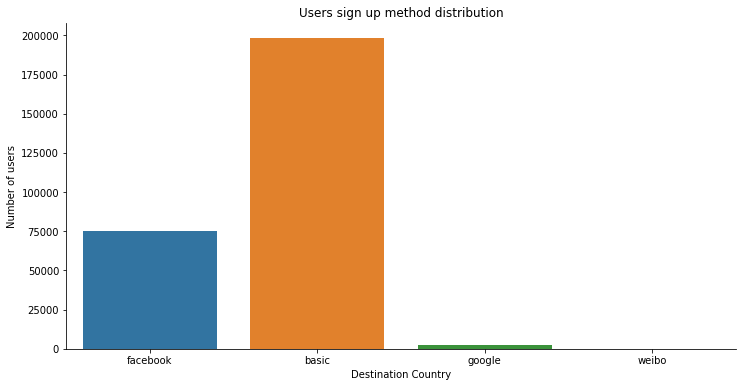

In [19]:
plt.figure(figsize=(12,6))

sns.countplot(x='signup_method', data = df_all)
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Users sign up method distribution')
sns.despine()


Over 70% of all bookers in the data used basic email method to sign up with Airbnb, and less than 30% of bookers used their facebook account to sign up, approx. only 0.26% of the bookers in the data used their Google accounts to sign up.

## Affiliate Channel

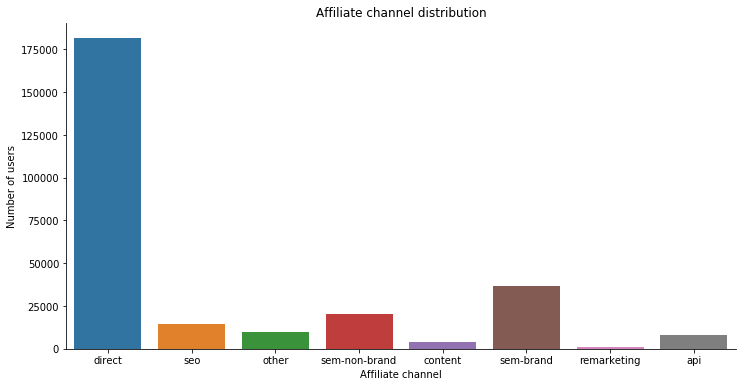

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(x='affiliate_channel', data=df_all)
plt.xlabel('Affiliate channel')
plt.ylabel('Number of users')
plt.title('Affiliate channel distribution')
sns.despine()

A large scale of customer sign up and make the booking directly without any optimization methods, this means that they have strong motivation and goal to start their trip using airbnb.

In [21]:

plt.figure(figsize=(18,6))
sns.countplot(x='first_device_type', data=df_all)
plt.xlabel('First device type')
plt.ylabel('Number of users')
plt.title('First device type distribution')
sns.despine()

First device type used for the booking is mostly mac and windows. More than 100000 number of users used Mac Desktop for their first booking

## User Session Exploration

Reading Session File

In [22]:
sessions = pd.read_csv('sessions.csv')

print("There were", len(sessions.user_id.unique()), " unique user IDs in the session data.")

There were 135484  unique user IDs in the session data.


In [23]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

## Action Type

In [24]:
sessions.action_type.unique()

array([nan, 'click', 'data', 'view', 'submit', 'message_post',
       '-unknown-', 'booking_request', 'partner_callback',
       'booking_response', 'modify'], dtype=object)

We have "NaN" and "unknown" in the action type. So we will change "unknown" to "NaN".

In [25]:
sessions.action_type.replace('-unknown-', np.nan, inplace = True)

# Action

Following describes the action performed by the user

In [43]:
sessions.action.value_counts().head(10)

show                     2768278
index                     843699
search_results            725226
personalize               706824
search                    536057
ajax_refresh_subtotal     487744
update                    365130
similar_listings          364624
social_connections        339000
reviews                   320591
Name: action, dtype: int64

## Device Type

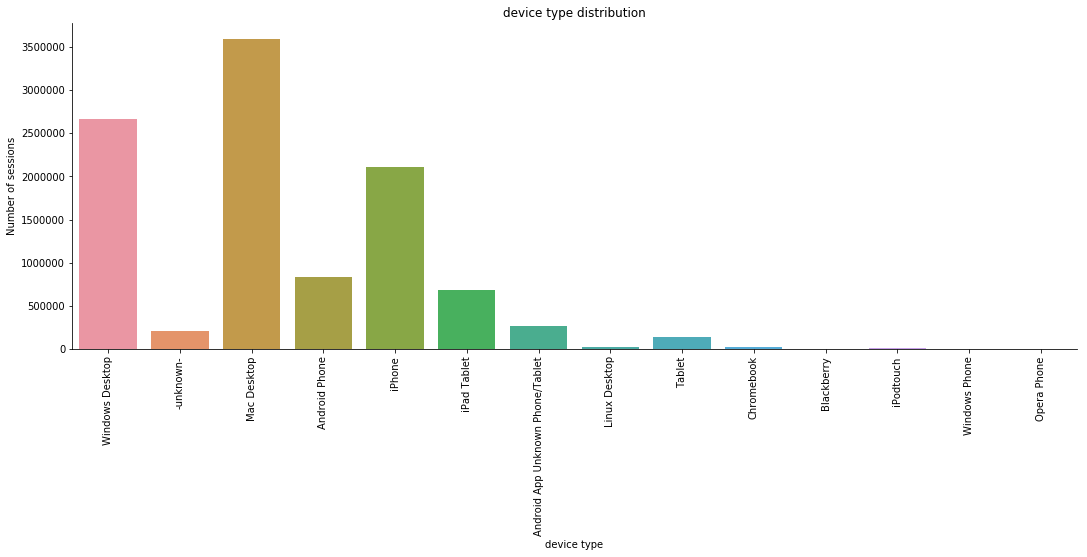

In [26]:
plt.figure(figsize=(18,6))
sns.countplot(x='device_type', data=sessions)
plt.xlabel('device type')
plt.ylabel('Number of sessions')
plt.title('device type distribution')
plt.xticks(rotation=90)
sns.despine()

This states the previous discovery about users. The most common device type among Airbnb users are Apple products. viz Mac-Desktop, iPhone, iPad Tablet

## Date Time Features

Cast date time column to property date time format, Split dates into day, month, year. 

In [27]:
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all = df_all.drop(['date_account_created'], axis=1)


In [28]:
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all = df_all.drop(['timestamp_first_active'], axis=1)

After dropping date_account_created and timestamp_first_active columns remaining in the dataset as follows

In [29]:
df_all.columns

Index(['gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser', 'dac_year',
       'dac_month', 'dac_day', 'tfa_year', 'tfa_month', 'tfa_day'],
      dtype='object')

## Encoding Categorial Features

getting the dummy values of categorial variables
In general, many machine learning algorithms (linear models, svm with common kernels etc.) cannot handle categorical data. Factorizing the data (i.e. coding each category with a number) doesn't help because that doesn't change the nature of the data, but just the values . In this case a transformation of the data is needed and the encoding is maybe the simplest one

In [30]:
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)

In [31]:
df_all.head()

age  dac_year  dac_month  dac_day  tfa_year  tfa_month  tfa_day  \
0  -1.0      2010          6       28      2009          3       19   
1  38.0      2011          5       25      2009          5       23   
2  56.0      2010          9       28      2009          6        9   
3  42.0      2011         12        5      2009         10       31   
4  41.0      2010          9       14      2009         12        8   

   gender_-unknown-  gender_FEMALE  gender_MALE            ...             \
0                 1              0            0            ...              
1                 0              0            1            ...              
2                 0              1            0            ...              
3                 0              1            0            ...              
4                 1              0            0            ...              

   first_browser_Silk  first_browser_SiteKiosk  first_browser_SlimBrowser  \
0                   0                        0                          0   
1                   0                        0                          0   
2                   0                        0                          0   
3                   0                        0                          0   
4                   0                        0                          0   

   first_browser_Sogou Explorer  first_browser_Stainless  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   first_browser_TenFourFox  first_browser_TheWorld Browser  \
0                         0                               0   
1                         0                               0   
2                         0                               0   
3                         0                               0   
4                         0                               0   

   first_browser_UC Browser  first_browser_Yandex.Browser  \
0                         0                             0   
1                         0                             0   
2                         0                             0   
3                         0                             0   
4                         0                             0   

   first_browser_wOSBrowser  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  

[5 rows x 161 columns]

Dividing the values into training and testing set to get best fit. Encode labels with value between 0 and n_classes-1. 

LabelEncoder()-This converts categorial data into numbers

In [32]:
vals = df_all.values
X = vals[:piv_train]
le = LabelEncoder()
y = le.fit_transform(labels)   
X_test = vals[piv_train:]

Implementing gradient boosted decision tree for speed and performance. and predicting the probability. Here I am using Max_Depth parameter 3, diving the samples into 0.5 sub parts and objective is to find ndcg rank

In [36]:
xgb = XGBClassifier(max_depth=3, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(X, y)
y_pred = xgb.predict_proba(X_test) 

## Normalized Discounted Cumulative Gain (NDCG)

The main component of NDCG is Discounted Cumulative Gain (DCG). When computing DCG we assume that documents with high relevance are more useful (higher gain) to users and should be ranked higher in a query result. Similarly, less relevant (lower gain) documents should be ranked lower

Two assumptions are made in using DCG and its related measures.

Highly relevant documents are more useful when appearing earlier in a search engine result list (have higher ranks)
Highly relevant documents are more useful than marginally relevant documents, which are in turn more useful than non-relevant documents.
DCG originates from an earlier, more primitive, measure called Cumulative Gain.

The evaluation metrics is NDCG @k where k=5. So we select top 5 Result

In [37]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()


Generating the submission file and storing the result into it

In [39]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('sub.csv',index=False)


# Conclusion

1. Removed the the age which is greater than 100 and less 16 as per the policy
2. Filled the value of gender which is not specified
3. Cast the date and time to get date and time of the booking
4. Encoded the Categorial Features for the best transformation
5. Implemented xgboosting for gettig best fit
6. Highest Normalized Discounted  Cumulative Gain(NDCG) score achieved is 0.86613 

# Contributions

By me- 40% Other Sources- 60%

# Citation

https://www.kaggle.com/svpons/three-level-classification-architecture

https://xgboost.readthedocs.io/en/latest/

https://github.com/RenXiangyuan/Kaggle-Airbnb-Recruit/blob/master/Data_Engineering.ipynb

https://github.com/nikhiljangam/Airbnb-new-user-bookings/blob/master/8.Final_notebook.ipynb

https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings

https://en.wikipedia.org/wiki/Discounted_cumulative_gain

# License

Copyright 2019 Vrushali Bandale

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE